In [1]:
import numpy
import urllib
import scipy.optimize
import random
from sklearn import linear_model
import gzip
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import string
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
def show_acc_by_stars(preds, actual):
    distri = Counter(actual)
    five = 0
    four = 0
    three = 0
    two = 0
    one = 0
    for x,y in zip(preds,actual):
        if x ==y:
            if y ==5.0:
                five+=1
            elif y ==4.0:
                four+=1
            elif y==3.0:
                three+=1
            elif y==2.0:
                two+=1
            else:
                one+=1
                
    one_text = "1 :   " + str(one/distri[1.0])
    two_text = "2 :   " + str(two/distri[2.0])
    three_text = "3 :   " + str(three/distri[3.0])
    four_text = "4 :   " + str(four/distri[4.0])
    five_text = "5 :   " + str(five/distri[5.0])
    overall_acc = "overall accuracy:       " + str(accuracy_score(preds,actual))
    
    print(one_text+'\n'+two_text+'\n'+three_text+'\n'+four_text+'\n' + five_text + '\n'+overall_acc)                

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [5]:
f = gzip.open("Digital_Music_5.json.gz")
dataset = []
for l in f:
    dataset.append(eval(l,{"true":True,"false":False,"null":None}))

In [6]:
len(dataset)

169781

In [7]:
dataset[0]

{'overall': 5.0,
 'vote': '3',
 'verified': True,
 'reviewTime': '06 3, 2013',
 'reviewerID': 'A2TYZ821XXK2YZ',
 'asin': '3426958910',
 'style': {'Format:': ' Audio CD'},
 'reviewerName': 'Garrett',
 'reviewText': 'This is awesome to listen to, A must-have for all Slayer fans..sadly needed to be a triple disc set..They have so many hits!!',
 'summary': 'Slayer Rules!',
 'unixReviewTime': 1370217600}

In [8]:
validSet = []
pairs = []
ratings = []
users = []
items = []

In [9]:
for data in dataset:
    if data['verified'] == True:
        validSet.append(data)
        ratings.append(data['overall'])
        pairs.append((data['reviewerID'], data['asin']))
        users.append(data['reviewerID'])
        items.append(data['asin'])

In [10]:
len(validSet)

148944

In [11]:
# Train 90%, Test 20%

In [48]:
train = validSet[:9*len(validSet)//10]
test = validSet[9*len(validSet)//10:]

In [49]:
Xtrain = pairs[:9*len(validSet)//10]
Xtest = pairs[9*len(validSet)//10:]

In [50]:
Ytrain = ratings[:9*len(validSet)//10]
Ytest = ratings[9*len(validSet)//10:]

In [51]:
distribution = Counter(ratings)
distribution

Counter({5.0: 121511, 4.0: 19621, 3.0: 5403, 2.0: 1044, 1.0: 1365})

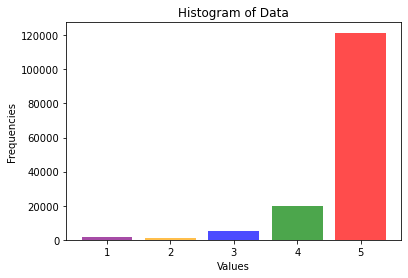

In [52]:
values, frequencies = zip(*distribution.items())

# Plot the histogram
colors = ['red', 'green', 'blue', 'orange', 'purple']
plt.bar(values, frequencies, color=colors, alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequencies')
plt.title('Histogram of Data')
plt.show()

In [53]:
train[0]

{'overall': 5.0,
 'vote': '3',
 'verified': True,
 'reviewTime': '06 3, 2013',
 'reviewerID': 'A2TYZ821XXK2YZ',
 'asin': '3426958910',
 'style': {'Format:': ' Audio CD'},
 'reviewerName': 'Garrett',
 'reviewText': 'This is awesome to listen to, A must-have for all Slayer fans..sadly needed to be a triple disc set..They have so many hits!!',
 'summary': 'Slayer Rules!',
 'unixReviewTime': 1370217600}

In [54]:
#Latent Factor Baseline 

In [55]:
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
    
for d in train:
    user,item = d['reviewerID'], d['asin']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)

In [56]:
globalAverage = sum(ratings) * 1.0 / len(ratings)

ratingsPerUser = defaultdict(set) # Maps an item to the users who rated it
ratingsPerItem = defaultdict(set) # Maps a user to the items that they rated
ratingDict = {} # To retrieve a rating for a specific user/item pair
    
for d in validSet:
    user,item,rate = d['reviewerID'], d['asin'], d['overall']
    ratingsPerItem[item].add(rate)
    ratingsPerUser[user].add(rate)
    ratingDict[(user,item)] = rate

In [57]:
betaU = {}
betaI = {}
for u in ratingsPerUser:
    betaU[u] = 0

for i in ratingsPerItem:
    betaI[i] = 0

alpha = globalAverage # Could initialize anywhere, this is a guess
lenTrain = len(Ytrain)

In [58]:
def iterate(lamb, alpha):
    diff = float('inf')
    obj = 0
    a = alpha
    
    while diff > 0.5:
        sum_1 = 0
        sum_2 = 0
        sum_3 = 0
        for d in Xtrain:
            sum_1 += (a + betaU[d[0]] + betaI[d[1]] - ratingDict[(d[0], d[1])])**2
        for u in ratingsPerUser:
            sum_2 += betaU[u]**2
        for i in ratingsPerItem:
            sum_2 += betaI[i]**2
        newObj = sum_1 + lamb*(sum_2+sum_3)
        diff = abs(obj - newObj)
        obj = newObj
        
        sum_a = 0
        for d in Xtrain:
            sum_a += ratingDict[(d[0], d[1])] - (betaI[d[1]] + betaU[d[0]])
        a = sum_a / lenTrain
            
        for d in Xtrain:
            sum_u = 0
            sum_i = 0
            
            for i in itemsPerUser[d[0]]:
                sum_u += ratingDict[(d[0], i)] - (a+betaI[i])
            betaU[d[0]] = sum_u / (lamb + len(itemsPerUser[d[0]]))
                
            for u in usersPerItem[d[1]]:
                sum_i += ratingDict[(u, d[1])] - (a+betaU[u])
            betaI[d[1]] = sum_i / (lamb + len(usersPerItem[d[1]]))
            
    return a

In [59]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [44]:
alpha = iterate(5, alpha)
predictRatings = []

for d in Xtest:
    if d[0] in betaU and d[1] in betaI:
        predictRatings.append(alpha + betaU[d[0]] + betaI[d[1]])
    else:
        predictRatings.append(5)

In [60]:
alpha = iterate(5, alpha)
predictRatings = []

for d in Xtest:
    if d[0] in betaU and d[1] in betaI:
        predictRatings.append(round(alpha + betaU[d[0]] + betaI[d[1]]))
    else:
        predictRatings.append(5)

In [61]:
validMSE = MSE(predictRatings, Ytest)
validMSE

0.43343403826787513

In [ ]:
#Jaccard Similarity-base rating prediction 

In [63]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [100]:
def mostSimilar(i):
    similarities = []
    if i not in usersPerItem: 
        return similarities
    user = usersPerItem[i]
    for i2 in usersPerItem:
        if i2 == i: continue
        sim = Jaccard(user, usersPerItem[i2])
        similarities.append(sim)
    similarities.sort(reverse=True)
    return similarities

In [101]:
len(Xtest)

29788

In [118]:
newTest = []
actualVal = []
for i in range(len(Xtest)):
    pair = (random.choice(users), random.choice(items))
    newTest.append(pair)
    if pair in ratingDict:
        actualVal.append(1)
    else:
        actualVal.append(0)

In [120]:
newTest = newTest + Xtest
actualVal = actualVal + [1]*len(Xtest)

59576 59576


In [122]:
threshold = 0.038
predictVal = []

for i in newTest:
    simis = mostSimilar(i[1])
    if len(simis)>0 and max(simis)>threshold:
        predictVal.append(1)
    else:
        predictVal.append(0)
        
correct = 0
for i in range(len(predictVal)):
    if predictVal[i] == actualVal[i]:
        correct += 1
        
acc = correct / len(predictVal)

In [123]:
acc

0.40868806230696925